In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import os
import numpy as np

solverpath_exe = 'C:\\Users\\Yuri Muniz\\OneDrive\\Documentos\\solvers\\ipopt-win64\\ipopt'

# N circles in a rectangle

Objective: minimize the surface area of a rectangle able to contain all circles (without intersection)

$$\min F(X,Y) = XY,$$

Circles inside rectangle constraint:

$$r_i \le x_i \le X - r_i, \,\, \forall \, i \in \{1,2,...,N\},$$
$$r_i \le y_i \le Y - r_i, \,\, \forall \, i \in \{1,2,...,N\},$$

No intersection between different circles:

$$(x_i - x_j)^2 + (y_i - y_j)^2 \ge (r_i + r_j)^2, \,\, \forall \, i > j \in \{1,2,...,N\},$$

where X and Y are the sides of a rectangle with bottom left vertex placed at the origin, $(x_i,y_i)$ are the coordinates of the center of circle $i$, and $r_i$ is its corresponding radius. The input parameters for this problem are $N$ and $r_i$.

In [2]:
# Defining an abstract model that should be the same for any number of circles (N) and radius (r_i)
model = AbstractModel()

# Params
model.N = Param()
model.i = RangeSet(1,model.N)
model.r = Param(model.i)


def lower_bound(model,i):
    return (model.r[i], None)

model.x = Var(model.i, bounds = lower_bound, within = NonNegativeReals, initialize = 0)
model.y = Var(model.i, bounds = lower_bound, within = NonNegativeReals, initialize = 0)
model.X = Var(initialize = 10)
model.Y = Var(initialize = 10)

# Constraints 1 and 2
def C1_rule(model,i):
    return model.x[i] <= model.X - model.r[i]

def C2_rule(model,i):
    return model.y[i] <= model.Y - model.r[i]

model.C1=Constraint(model.i, rule = C1_rule)
model.C2=Constraint(model.i, rule = C2_rule)

# Constraint 3
def C3_rule(model, i, j):
    if i > j:
        return (model.x[i] - model.x[j])**2 + (model.y[i] - model.y[j])**2 >= (model.r[i] + model.r[j])**2
    else:
        return Constraint.Skip

model.C3=Constraint(model.i, model.i, rule = C3_rule)

# Objective
model.F=Objective(expr = model.X*model.Y, sense = minimize)

# ipopt solver
opt = SolverFactory('ipopt', executable=solverpath_exe)

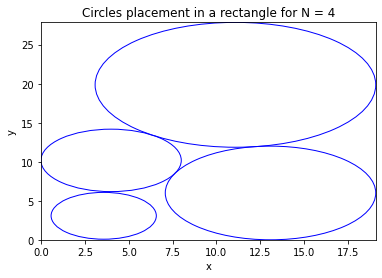

In [3]:
# Creating dictionary with parameters to feed the model
r_list = [6,3,4,8]
circles_dict =  {None:
    {'N':{None:len(r_list)},
     'r':{i+1:r for i,r in enumerate(r_list)}
    }
                }

instance = model.create_instance(circles_dict)
results = opt.solve(instance)

# Plotting
ri = [value(instance.r[i]) for i in instance.i]
xi = [value(instance.x[i]) for i in instance.i]
yi = [value(instance.y[i]) for i in instance.i]

ax = plt.gca()
for i, r_i in enumerate(ri):
    circle = plt.Circle((xi[i],yi[i]),r_i, linestyle='-', fill=False, color='blue')
    ax.add_patch(circle)

plt.xlim([0,value(instance.X)])
plt.ylim([0,value(instance.Y)])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Circles placement in a rectangle for N = '+str(value(instance.N)))
plt.show()

# N circles in a bigger circle

Objective: minimize the surface area of a circle able to contain all other circles (without intersection)

$$\min F(R) = \pi R^2,$$

Circles inside bigger circle constraint:

$$x_i^2 + y_i^2 \le (R - r_i)^2, \,\, \forall \, i \in \{1,2,...,N\},$$

No intersection between different circles:

$$(x_i - x_j)^2 + (y_i - y_j)^2 \ge (r_i + r_j)^2, \,\, \forall \, i > j \in \{1,2,...,N\},$$

where R is the vertex of the bigger circle centered at the origin, $(x_i,y_i)$ are the coordinates of the center of circle $i$, and $r_i$ is its corresponding radius. The input parameters for this problem are $N$ and $r_i$.

In [4]:
# Defining an abstract model that should be the same for any number of circles (N) and radius (r_i)
model = AbstractModel()

# Params
model.N = Param()
model.i = RangeSet(1,model.N)
model.r = Param(model.i)

# Defining variables
model.x = Var(model.i, within = Reals, initialize = -1)
model.y = Var(model.i, within = Reals, initialize = 1)
model.R = Var(bounds=(0,None), initialize = 10)

# Constraint 1
def C1_rule(model,i):
    return model.x[i]**2 + model.y[i]**2 <= (model.R - model.r[i])**2

model.C1=Constraint(model.i, rule = C1_rule)

# Constraint 2
def C2_rule(model, i, j):
    if i > j:
        return (model.x[i] - model.x[j])**2 + (model.y[i] - model.y[j])**2 >= (model.r[i] + model.r[j])**2
    else:
        return Constraint.Skip

model.C3=Constraint(model.i, model.i, rule = C2_rule)

# Objective
model.F=Objective(expr = np.pi*model.R**2, sense = minimize)
 
# Alternatively, we could minimize only the radius and have a linear problem. Check if the answer is the same with the below objective function (comment the above objective to check that)
#model.F=Objective(expr = model.R, sense = minimize) 

# ipopt solver
opt = SolverFactory('ipopt', executable=solverpath_exe)

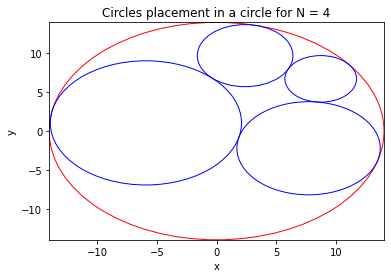

In [5]:
# Creating dictionary with parameters to feed the model
r_list = [6,3,4,8]
circles_dict =  {None:
    {'N':{None:len(r_list)},
     'r':{i+1:r for i,r in enumerate(r_list)}
    }
                }

instance = model.create_instance(circles_dict)
results = opt.solve(instance)

# Plotting
ri = [value(instance.r[i]) for i in instance.i]
xi = [value(instance.x[i]) for i in instance.i]
yi = [value(instance.y[i]) for i in instance.i]

ax = plt.gca()
# Adding external circle
circle = plt.Circle((0,0),value(instance.R), linestyle='-', fill=False, color='red')
ax.add_patch(circle)
# Adding inner circles
for i, r_i in enumerate(ri):
    circle = plt.Circle((xi[i],yi[i]),r_i, linestyle='-', fill=False, color='blue')
    ax.add_patch(circle)

plt.xlim([-value(instance.R),value(instance.R)])
plt.ylim([-value(instance.R),value(instance.R)])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Circles placement in a circle for N = '+str(value(instance.N)))
plt.show()